In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ===============================
# Pima Indians Diabetes - Handling Imbalanced Data
# ===============================

In [59]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc,confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier


# Load dataset

In [60]:

df=pd.read_csv('/content/drive/MyDrive/0.Latest_DS_Course/Ensemble/1.Bagging/Diabetes.csv')

X = df.drop("Outcome", axis=1)
y = df["Outcome"]




#Check Class Distribution

<Axes: xlabel='Outcome', ylabel='count'>

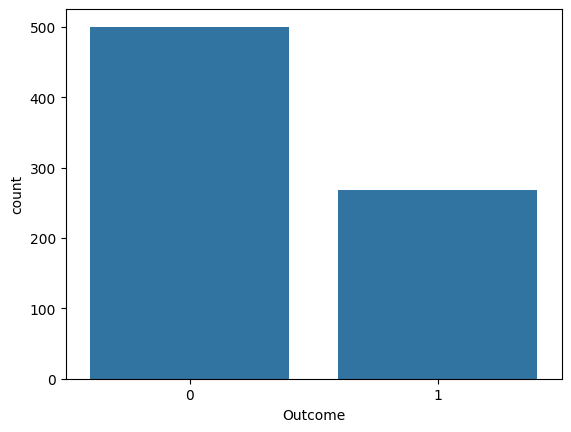

In [61]:
sns.countplot(data=df, x="Outcome")

In [62]:
df["Outcome"].value_counts()

,count
Outcome,
0,500
1,268


# Train-test split

In [63]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
print('Original Training class distribution:', pd.Series(y_train).value_counts())


Original Training class distribution: Outcome
0    400
1    214
Name: count, dtype: int64


###2. Define Helper Function

In [65]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"--- {name} ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_prob)
    print("ROC AUC:", auc_score)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    return fpr, tpr, auc_score


#Baseline Models:

In [76]:

# Logistic Regression
fpr_lr_rus, tpr_lr_rus, auc_lr_rus = evaluate_model(LogisticRegression(), X_train_scaled, y_train, X_test_scaled, y_test, "Logistic - baseline")

# SVM
fpr_svm_rus, tpr_svm_rus, auc_svm_rus = evaluate_model(SVC(probability=True), X_train_scaled, y_train, X_test_scaled, y_test, "SVM - baseline")

# XGBoost
fpr_xgb_rus, tpr_xgb_rus, auc_xgb_rus = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                                                       X_train_scaled, y_train, X_test_scaled, y_test, "XGB - baseline")


--- Logistic - baseline ---
[[82 18]
 [26 28]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154

ROC AUC: 0.8229629629629629
--- SVM - baseline ---
[[83 17]
 [21 33]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

ROC AUC: 0.7922222222222222
--- XGB - baseline ---
[[80 20]
 [21 33]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       100
           1       0.62      0.61      0.62       

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###3. Undersampling

In [66]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_scaled, y_train)

print('Resampled class distribution:', pd.Series(y_res).value_counts())


Resampled class distribution: Outcome
0    214
1    214
Name: count, dtype: int64


#Models after undersampling

In [67]:

# Logistic Regression
fpr_lr_rus, tpr_lr_rus, auc_lr_rus = evaluate_model(LogisticRegression(), X_res, y_res, X_test_scaled, y_test, "Logistic - Undersampling")

# SVM
fpr_svm_rus, tpr_svm_rus, auc_svm_rus = evaluate_model(SVC(probability=True), X_res, y_res, X_test_scaled, y_test, "SVM - Undersampling")

# XGBoost
fpr_xgb_rus, tpr_xgb_rus, auc_xgb_rus = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                                                       X_res, y_res, X_test_scaled, y_test, "XGB - Undersampling")


--- Logistic - Undersampling ---
[[74 26]
 [14 40]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       100
           1       0.61      0.74      0.67        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.76      0.74      0.74       154

ROC AUC: 0.8227777777777778
--- SVM - Undersampling ---
[[66 34]
 [13 41]]
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       100
           1       0.55      0.76      0.64        54

    accuracy                           0.69       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.73      0.69      0.70       154

ROC AUC: 0.7885185185185186
--- XGB - Undersampling ---
[[70 30]
 [15 39]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.76       100
           1       0.57      0.72  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:08:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###4. Oversampling

In [68]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)
print('Resampled class distribution:', pd.Series(y_res).value_counts())


Resampled class distribution: Outcome
0    400
1    400
Name: count, dtype: int64


Models after oversampling

In [69]:

# Logistic
fpr_lr_ros, tpr_lr_ros, auc_lr_ros = evaluate_model(LogisticRegression(), X_res, y_res, X_test_scaled, y_test, "Logistic - Oversampling")

# SVM
fpr_svm_ros, tpr_svm_ros, auc_svm_ros = evaluate_model(SVC(probability=True), X_res, y_res, X_test_scaled, y_test, "SVM - Oversampling")

# XGB
fpr_xgb_ros, tpr_xgb_ros, auc_xgb_ros = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                                                       X_res, y_res, X_test_scaled, y_test, "XGB - Oversampling")


--- Logistic - Oversampling ---
[[75 25]
 [16 38]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154

ROC AUC: 0.8227777777777778
--- SVM - Oversampling ---
[[71 29]
 [10 44]]
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       100
           1       0.60      0.81      0.69        54

    accuracy                           0.75       154
   macro avg       0.74      0.76      0.74       154
weighted avg       0.78      0.75      0.75       154

ROC AUC: 0.7978703703703703
--- XGB - Oversampling ---
[[77 23]
 [19 35]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       100
           1       0.60      0.65     

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:08:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###5. SMOTE

In [70]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
print('Resampled class distribution:', pd.Series(y_res).value_counts())


Resampled class distribution: Outcome
0    400
1    400
Name: count, dtype: int64


In [71]:

# Logistic
fpr_lr_sm, tpr_lr_sm, auc_lr_sm = evaluate_model(LogisticRegression(), X_res, y_res, X_test_scaled, y_test, "Logistic - SMOTE")

# SVM
fpr_svm_sm, tpr_svm_sm, auc_svm_sm = evaluate_model(SVC(probability=True), X_res, y_res, X_test_scaled, y_test, "SVM - SMOTE")

# XGB
fpr_xgb_sm, tpr_xgb_sm, auc_xgb_sm = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
                                                    X_res, y_res, X_test_scaled, y_test, "XGB - SMOTE")


--- Logistic - SMOTE ---
[[76 24]
 [16 38]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       100
           1       0.61      0.70      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154

ROC AUC: 0.8203703703703704
--- SVM - SMOTE ---
[[66 34]
 [11 43]]
              precision    recall  f1-score   support

           0       0.86      0.66      0.75       100
           1       0.56      0.80      0.66        54

    accuracy                           0.71       154
   macro avg       0.71      0.73      0.70       154
weighted avg       0.75      0.71      0.71       154

ROC AUC: 0.7866666666666666
--- XGB - SMOTE ---
[[76 24]
 [17 37]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       100
           1       0.61      0.69      0.64        54

    

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:08:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###6. Class Weighing

In [72]:
# Logistic
fpr_lr_cw, tpr_lr_cw, auc_lr_cw = evaluate_model(LogisticRegression(class_weight="balanced"), X_train_scaled, y_train, X_test_scaled, y_test, "Logistic - Class Weighing")

# SVM
fpr_svm_cw, tpr_svm_cw, auc_svm_cw = evaluate_model(SVC(probability=True, class_weight="balanced"), X_train_scaled, y_train, X_test_scaled, y_test, "SVM - Class Weighing")

# XGB
fpr_xgb_cw, tpr_xgb_cw, auc_xgb_cw = evaluate_model(XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), use_label_encoder=False, eval_metric="logloss"),
                                                    X_train_scaled, y_train, X_test_scaled, y_test, "XGB - Class Weighing")


--- Logistic - Class Weighing ---
[[75 25]
 [16 38]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154

ROC AUC: 0.8248148148148148
--- SVM - Class Weighing ---
[[66 34]
 [12 42]]
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       100
           1       0.55      0.78      0.65        54

    accuracy                           0.70       154
   macro avg       0.70      0.72      0.69       154
weighted avg       0.74      0.70      0.71       154

ROC AUC: 0.7929629629629629
--- XGB - Class Weighing ---
[[80 20]
 [22 32]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       100
           1       0.62      0.5

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:08:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###7. Balanced Random Forest

In [73]:
brf = BalancedRandomForestClassifier(random_state=42, n_estimators=100)
fpr_brf, tpr_brf, auc_brf = evaluate_model(brf, X_train, y_train, X_test, y_test, "Balanced Random Forest")


--- Balanced Random Forest ---
[[74 26]
 [17 37]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.59      0.69      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154

ROC AUC: 0.811574074074074


###8. Easy Ensemble

In [74]:
eec = EasyEnsembleClassifier(random_state=42, n_estimators=50)
fpr_eec, tpr_eec, auc_eec = evaluate_model(eec, X_train, y_train, X_test, y_test, "Easy Ensemble")


--- Easy Ensemble ---
[[74 26]
 [14 40]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       100
           1       0.61      0.74      0.67        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.76      0.74      0.74       154

ROC AUC: 0.8231481481481482


###9. Compare ROC Curves

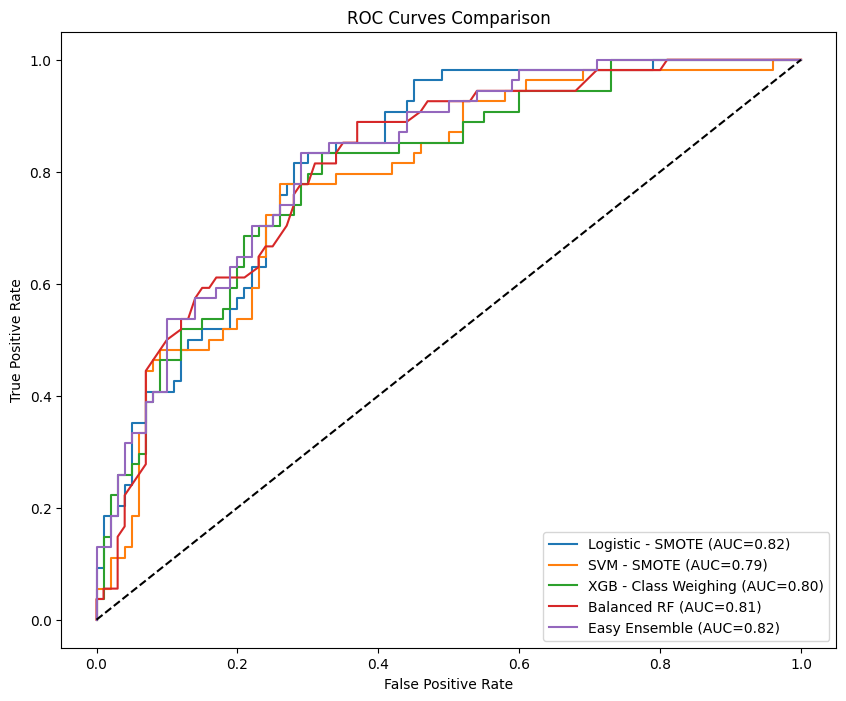

In [77]:
plt.figure(figsize=(10,8))


plt.plot(fpr_lr_sm, tpr_lr_sm, label=f"Logistic - SMOTE (AUC={auc_lr_sm:.2f})")
plt.plot(fpr_svm_sm, tpr_svm_sm, label=f"SVM - SMOTE (AUC={auc_svm_sm:.2f})")
plt.plot(fpr_xgb_cw, tpr_xgb_cw, label=f"XGB - Class Weighing (AUC={auc_xgb_cw:.2f})")
plt.plot(fpr_brf, tpr_brf, label=f"Balanced RF (AUC={auc_brf:.2f})")
plt.plot(fpr_eec, tpr_eec, label=f"Easy Ensemble (AUC={auc_eec:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()
